<a href="https://colab.research.google.com/github/nihalsuri/thermal-anomaly-detection/blob/main/notebooks/tad_mobilenetv3_small_rpi_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading all necessary data when connected to host

In [ ]:
! gdown --id 1x4Os51uaMXDILTGo2Y_lOC9HU1jTnzi0
! gdown --id 1uxDV-sgzDUATHc5p8gW_gBKBsEVrz34x

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!unzip clutch_2.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Uploading data when connected to local runtime 

In [1]:
annotations_path = 'C:/Users/Nihal/Desktop/thesis/dataset.csv'
# annotations_path = 'C:/Users/Nihal/Desktop/new_dataset.csv'
dataset_path = 'C:/Users/Nihal/Desktop/thesis/clutch_2'

# Data preperation for training

In this section the following is done: 



*   Data is processed and arranged into respective **dataframes** 
*   **Custom dataset** class is created 
*   **Transforms** are done on the various datasets
*   **Dataloaders** are created for the purposes of iteration





## Import libraries

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from torchvision import transforms , models
from sklearn import metrics
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import io
import copy
import tqdm 
import time 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name()
print(device_name)
print(device)

NVIDIA GeForce GTX 1660 Ti with Max-Q Design
cuda


In [4]:
torch.cuda.empty_cache()

In [5]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

## Split data into dataframes

In [6]:
df = pd.read_csv(annotations_path)
train_df = df[df['dataset'].str.contains('train')]
test_df = df[df['dataset'].str.contains('test')]
val_df = df[df['dataset'].str.contains('val')]
print(train_df.shape[0])
print(test_df.shape[0])
print(val_df.shape[0])

2703
651
648


In [ ]:
# img_paths = df["img_path"]

In [ ]:
# for i in range(img_paths.shape[0]):
#   size  = len(img_paths.at[i])
#   new_path = img_paths.at[i][:size - 24]
#   img_paths.at[i] = new_path


In [ ]:
# img_paths.head()

In [ ]:
# unique_lables = img_paths.unique().tolist()


In [ ]:
# df_freq = img_paths.value_counts()
# df_freq

## Custom Class 
Returns **image** and **label** for futher training

In [7]:
class ClutchDataset(Dataset):

    def __init__(self, dataframe, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1])
        image1 = cv2.imread(img_name)
        image_norm = cv2.normalize(
            image1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        image = Image.fromarray(image_norm)
        label = torch.tensor(int(self.dataframe.iloc[idx, 2]))
         


        if self.transform:
            image = self.transform(image)
        
        #image = transforms.functional.crop(image, 140, 360 , 240, 240) # take only right part of the system
        #image = transforms.functional.crop(image, 220, 460 , 160, 160) # take only right tip of the system 1 
        #image = transforms.functional.crop(image, 190, 510 , 140, 110) # more right 2
        #image = transforms.functional.crop(image, 190, 470 , 140, 140) # more right 3
        #image = transforms.functional.crop(image, 190, 440 , 140, 180) # more right 4
        #image = transforms.functional.crop(image, 190, 470 , 130, 150) # more right 5
        
        #image = transforms.functional.crop(image, 190, 285 , 140, 320) # mm
        image = transforms.functional.crop(image, 190, 380 , 140, 230)
        #image = transforms.functional.crop(image, 190, 430 , 140, 180) #6

        return image, label

## Transforms on the datasets

In [8]:
# Add transforms for train, test, val dataset
input_size_h = 512
input_size_w = 640
transform_train = transforms.Compose([
   #transforms.Resize((input_size_h, input_size_w)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.RandomPerspective(),
    #transforms.RandomRotation((1, 8))

])

transform_valid = transforms.Compose([
    #transforms.Resize((input_size_h, input_size_w)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    #transforms.Resize((input_size_h, input_size_w)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

## Dataloaders and Iterator

Feature batch shape: torch.Size([8, 3, 140, 230])
Labels batch shape: torch.Size([8])


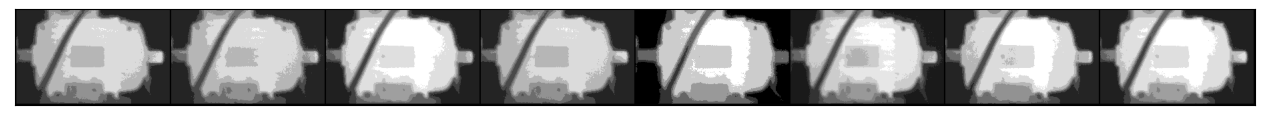

In [9]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break



# dataloaders
train_dataset = ClutchDataset(
    train_df, root_dir=dataset_path, is_train=True, transform=transform_train)
val_dataset = ClutchDataset(val_df, root_dir=dataset_path,
                            is_train=False, transform=transform_valid)
test_dataset = ClutchDataset(
    test_df, root_dir=dataset_path, is_train=False, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader
dataloaders_dict['test'] = test_loader


# iteratre through dataloaders
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]

# convert image to APPEAR RGB
# rgb_train_features = np.repeat(train_features[..., np.newaxis], 3, -1)
# print(f"Feature batch shape: {rgb_train_features.shape}")
# train_features = rgb_train_features

# plt.imshow(img, cmap="gray")
# plt.axis('off')
# plt.show()
# print(f"Label: {label}")
show_batch(train_loader)






# Neural Networks
Various different NNs tested with the same dataset

### Metrics

In [10]:
def get_metrics(y_true, y_pred, class_mapping):

    total_predictions = [0, 0, 0]
    total_true = [0, 0, 0]

    cm = metrics.confusion_matrix(y_true, y_pred, labels=class_mapping)

    for i in range(3):
        for j in range(3):
            total_predictions[i] += cm[j][i]
            total_true[i] += cm[i][j]

    # recall and precision for each class
    r_h = cm[0][0] / total_predictions[0]
    r_m = cm[1][1] / total_predictions[1]
    r_r = cm[2][2] / total_predictions[2]
    p_h = cm[0][0] / total_true[0]
    p_m = cm[1][1] / total_true[1]
    p_r = cm[2][2] / total_true[2]

    # data for confusion matrix
    data = [["", class_mapping[0], class_mapping[1], class_mapping[2], "Total actual"],
            [class_mapping[0], cm[0][0], cm[0][1], cm[0][2], total_true[0]],
            [class_mapping[1], cm[1][0], cm[1][1], cm[1][2], total_true[1]],
            [class_mapping[2], cm[2][0], cm[2][1], cm[2][2], total_true[2]],
            ["Total predicted:", total_predictions[0], total_predictions[1], total_predictions[2], sum(total_true)]]

    # data for f1 score for each class
    data_f1 = [["Class", "F1-score"],
               ["Healthy", round((2 * p_h * r_h) / (p_h + r_h), 2)],
               ["Misalignment", round((2 * p_m * r_m) / (p_m + r_m), 2)],
               ["Rotor damage", round((2 * p_r * r_r) / (p_r + r_r), 2)]]

    # printing confusion matrix, f1 score table, recall and precision
    print(tabulate(data, tablefmt="simple_grid"))
    print()
    print(tabulate(data_f1, tablefmt="simple_grid"))
    print(f"\nRecall for healthy class: {round(r_h, 2)}")
    print(f"Recall for misalignment class: {round(r_m, 2)}")
    print(f"Recall for rotor damage class: {round(r_r, 2)}")
    print(f"\nPrecision for healthy class: {round(p_h, 2)}")
    print(f"Precision for misalignment class: {round(p_m, 2)}")
    print(f"Precision for rotor damage class: {round(p_r, 2)}")

## MobileNet V3( Transfer Learning )

With the resnet152 architecture instead of developing the DNN(Dense Neural Network) on our own we take a **transfer learning approach**, so the **classification** block will be modified and the input into the first **convolutional block** will be made to look-like its 3-channel as the pretrained model accepts ony 3-channel images, this is done by taking the same grayscale image and mapping it onto the three axes. 

### Pretrained Model



In [11]:
mobileNet = models.mobilenet_v3_small(pretrained=True)
mobileNet = mobileNet.cuda() if device else mobileNet
mobileNet

c:\users\nihal\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\users\nihal\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Changes to pretrained model to fit dataset

In [12]:
mobileNet.classifier[3] = nn.Linear(in_features = 1024,out_features=  3, bias= True)
mobileNet.classifier[3] = mobileNet.classifier[3].cuda()
mobileNet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Hyperparameters

In [16]:
path_res = "C:/Users/Nihal/Desktop/thermal-anomaly-detection/models/mobilenetv3-1-small.pt"
LEARNING_RATE = 3e-4

loss_val = []
train_acc = []
class_mapping = ['healthy', 'misalignment', 'rotor damage']

### Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Training per epoch


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobileNet.parameters(), lr=LEARNING_RATE, momentum=0.9)
n_epochs = 120
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
early_stopper = EarlyStopper(patience=8, min_delta=0.1)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = mobileNet(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        mobileNet.eval()
        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = mobileNet(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(mobileNet.state_dict(), path_res)
            print('Improvement-Detected, save-model')

        if early_stopper.early_stop(batch_loss/len(test_loader)):
            print("Patience Extended! Training stopped...")
            break

        

    mobileNet.train()










Epoch 1

Epoch [1/120], Step [0/338], Loss: 1.0624
Epoch [1/120], Step [10/338], Loss: 1.0900
Epoch [1/120], Step [20/338], Loss: 0.9643
Epoch [1/120], Step [30/338], Loss: 0.8843
Epoch [1/120], Step [40/338], Loss: 0.9127
Epoch [1/120], Step [50/338], Loss: 0.6664
Epoch [1/120], Step [60/338], Loss: 0.8291
Epoch [1/120], Step [70/338], Loss: 0.5629
Epoch [1/120], Step [80/338], Loss: 0.6430
Epoch [1/120], Step [90/338], Loss: 0.3177
Epoch [1/120], Step [100/338], Loss: 0.3273
Epoch [1/120], Step [110/338], Loss: 0.3189
Epoch [1/120], Step [120/338], Loss: 0.2918
Epoch [1/120], Step [130/338], Loss: 0.2322
Epoch [1/120], Step [140/338], Loss: 0.3177
Epoch [1/120], Step [150/338], Loss: 0.2005
Epoch [1/120], Step [160/338], Loss: 0.3444
Epoch [1/120], Step [170/338], Loss: 0.3669
Epoch [1/120], Step [180/338], Loss: 0.2381
Epoch [1/120], Step [190/338], Loss: 0.2028
Epoch [1/120], Step [200/338], Loss: 0.1194
Epoch [1/120], Step [210/338], Loss: 0.0783
Epoch [1/120], Step [220/338], Los

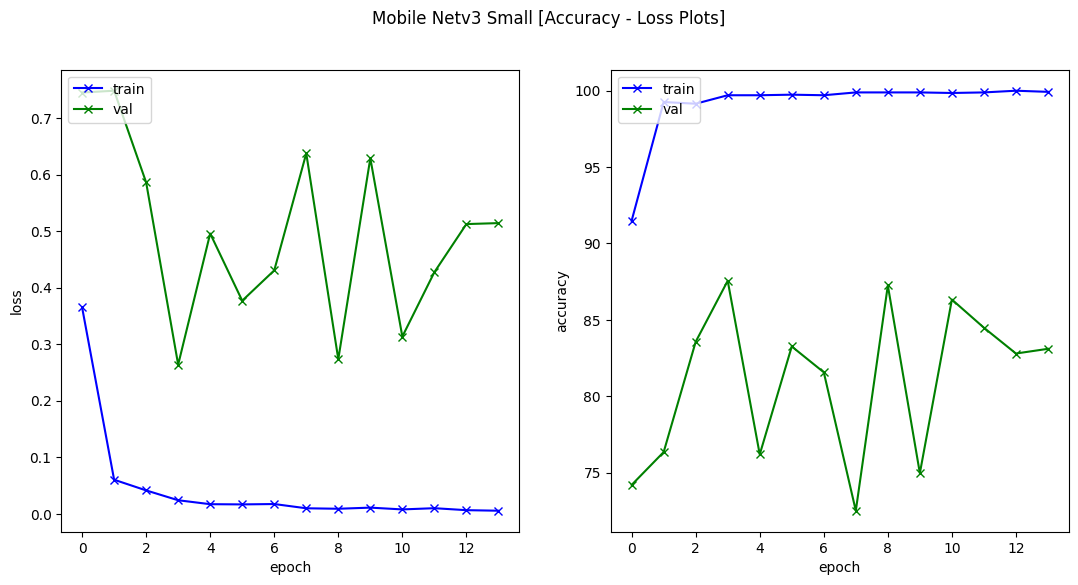

In [ ]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(13)

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'bx-', label = 'train')
plt.plot(val_loss, 'gx-', label = 'val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plt.plot(train_acc, 'bx-', label = 'train')
plt.plot(val_acc, 'gx-', label = 'val')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc = 'upper left')


fig.suptitle('Mobile Netv3 Small [Accuracy - Loss Plots]')
plt.show()

### Predictions

#### Test

In [17]:
model_mobv3 = mobileNet
model_mobv3.load_state_dict(torch.load(path_res))


print('Test data: ')
y_true = []
y_pred = []

for i in range(len(test_dataset)):
    input, target = test_dataset[i][0], test_dataset[i][1]
    model_mobv3.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        input = input.to(device) # send data to GPU 
        predictions = model_mobv3(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Test data: 
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 142     │ 64           │ 0            │ 206          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 0       │ 229          │ 0            │ 229          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 0       │ 0            │ 216          │ 216          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 142     │ 293          │ 216          │ 651          │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ 0.82     │
├──────────────┼──────────┤
│ Misalignm

#### Validation

In [ ]:
print('Valid data: ')
y_true = []
y_pred = []

for i in range(len(val_dataset)):
    input, target = val_dataset[i][0], val_dataset[i][1]
    model_mobv3.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        input = input.to(device) # send data to GPU 
        predictions = model_mobv3(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Valid data: 
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 188     │ 1            │ 10           │ 199          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 0       │ 220          │ 0            │ 220          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 0       │ 0            │ 229          │ 229          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 188     │ 221          │ 239          │ 648          │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ 0.97     │
├──────────────┼──────────┤
│ Misalign

#### Training

In [ ]:
print('Training data:')
y_true = []
y_pred = []

for i in range(len(train_dataset)):
    input, target = train_dataset[i][0], train_dataset[i][1]
    model_mobv3.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        input = input.to(device) # send data to GPU
        predictions = model_mobv3(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Training data:


KeyboardInterrupt: ignored

### Different Style of Training

In [ ]:
# n_epochs = 20
# print_every = 10
# valid_loss_min = np.Inf
# val_loss = []
# val_acc = []
# train_loss = []
# train_acc = []
# total_step = len(train_loader)
# for epoch in range(1, n_epochs+1):
#     running_loss = 0.0
#     correct = 0
#     total=0
#     print(f'Epoch {epoch}\n')
#     for batch_idx, (data_, target_) in enumerate(train_loader):
#         data_, target_ = data_.to(device), target_.to(device)
#         optimizer.zero_grad()
        
#         outputs = resnet(data_)
#         loss = criterion(outputs, target_)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _,pred = torch.max(outputs, dim=1)
#         correct += torch.sum(pred==target_).item()
#         total += target_.size(0)
#         if (batch_idx) % 20 == 0:
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                    .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
#     train_acc.append(100 * correct / total)
#     train_loss.append(running_loss/total_step)
#     print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
#     batch_loss = 0
#     total_t=0
#     correct_t=0
#     with torch.no_grad():
#         resnet.eval()
#         for data_t, target_t in (test_loader):
#             data_t, target_t = data_t.to(device), target_t.to(device)
#             outputs_t = resnet(data_t)
#             loss_t = criterion(outputs_t, target_t)
#             batch_loss += loss_t.item()
#             _,pred_t = torch.max(outputs_t, dim=1)
#             correct_t += torch.sum(pred_t==target_t).item()
#             total_t += target_t.size(0)
#         val_acc.append(100 * correct_t/total_t)
#         val_loss.append(batch_loss/len(test_loader))
#         network_learned = batch_loss < valid_loss_min
#         print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
#         if network_learned:
#             valid_loss_min = batch_loss
#             torch.save(resnet.state_dict(), "C:/Users/Nihal/Desktop/thesis/resnet18_train2.pt")
#             print('Improvement-Detected, save-model')
#     resnet.train()

### Train - Validation Accuracy 

In [ ]:
# fig = plt.figure(figsize=(20,10))
# plt.title("Train-Validation Accuracy")
# plt.plot(train_acc, label='train')
# plt.plot(val_acc, label='validation')
# plt.xlabel('num_epochs', fontsize=12)
# plt.ylabel('accuracy', fontsize=12)
# plt.legend(loc='best')

### Visualize Results

In [ ]:
# def visualize_model(net, num_images=4):
#     images_so_far = 0
#     fig = plt.figure(figsize=(15, 10))
    
#     for i, data in enumerate(test_dataloader):
#         inputs, labels = data
#         if use_cuda:
#             inputs, labels = inputs.cuda(), labels.cuda()
#         outputs = net(inputs)
#         _, preds = torch.max(outputs.data, 1)
#         preds = preds.cpu().numpy() if use_cuda else preds.numpy()
#         for j in range(inputs.size()[0]):
#             images_so_far += 1
#             ax = plt.subplot(2, num_images//2, images_so_far)
#             ax.axis('off')
#             ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
#             imshow(inputs[j])
            
#             if images_so_far == num_images:
#                 return 

# plt.ion()
# visualize_model(net)
# plt.ioff()